# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [3]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [11]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [12]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [19]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [14]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 1ms/sample - loss: 225.2559 - y1_output_loss: 108.8600 - y2_output_loss: 114.9258 - y1_output_root_mean_squared_error: 10.4686 - y2_output_root_mean_squared_error: 10.7547 - val_loss: 85.2384 - val_y1_output_loss: 25.4769 - val_y2_output_loss: 56.7918 - val_y1_output_root_mean_squared_error: 5.1240 - val_y2_output_root_mean_squared_error: 7.6801
Epoch 2/500
614/614 [==============================] - 0s 156us/sample - loss: 28.5956 - y1_output_loss: 12.6656 - y2_output_loss: 15.7620 - y1_output_root_mean_squared_error: 3.5698 - y2_output_root_mean_squared_error: 3.9815 - val_loss: 21.8574 - val_y1_output_loss: 8.9168 - val_y2_output_loss: 12.4091 - val_y1_output_root_mean_squared_error: 3.0094 - val_y2_output_root_mean_squared_error: 3.5779
Epoch 3/500
614/614 [==============================] - 0s 150us/sample - loss: 26.5066 - y1_output_loss: 11.5434 - y2_output_loss: 16.0106 - y1_ou

614/614 [==============================] - 0s 148us/sample - loss: 9.0992 - y1_output_loss: 3.0420 - y2_output_loss: 6.1287 - y1_output_root_mean_squared_error: 1.7296 - y2_output_root_mean_squared_error: 2.4713 - val_loss: 9.3335 - val_y1_output_loss: 3.0581 - val_y2_output_loss: 6.0825 - val_y1_output_root_mean_squared_error: 1.7643 - val_y2_output_root_mean_squared_error: 2.4941
Epoch 42/500
614/614 [==============================] - 0s 140us/sample - loss: 9.1020 - y1_output_loss: 2.9239 - y2_output_loss: 6.1342 - y1_output_root_mean_squared_error: 1.7109 - y2_output_root_mean_squared_error: 2.4849 - val_loss: 12.0383 - val_y1_output_loss: 2.0850 - val_y2_output_loss: 9.5408 - val_y1_output_root_mean_squared_error: 1.4670 - val_y2_output_root_mean_squared_error: 3.1442
Epoch 43/500
614/614 [==============================] - 0s 147us/sample - loss: 8.0839 - y1_output_loss: 2.6672 - y2_output_loss: 5.3600 - y1_output_root_mean_squared_error: 1.6395 - y2_output_root_mean_squared_error

Epoch 62/500
614/614 [==============================] - 0s 138us/sample - loss: 5.4978 - y1_output_loss: 1.4188 - y2_output_loss: 4.0403 - y1_output_root_mean_squared_error: 1.1936 - y2_output_root_mean_squared_error: 2.0182 - val_loss: 4.7088 - val_y1_output_loss: 1.1770 - val_y2_output_loss: 3.3915 - val_y1_output_root_mean_squared_error: 1.1001 - val_y2_output_root_mean_squared_error: 1.8704
Epoch 63/500
614/614 [==============================] - 0s 140us/sample - loss: 5.7630 - y1_output_loss: 1.5935 - y2_output_loss: 4.1438 - y1_output_root_mean_squared_error: 1.2657 - y2_output_root_mean_squared_error: 2.0399 - val_loss: 4.4389 - val_y1_output_loss: 1.0695 - val_y2_output_loss: 3.2306 - val_y1_output_root_mean_squared_error: 1.0492 - val_y2_output_root_mean_squared_error: 1.8270
Epoch 64/500
614/614 [==============================] - 0s 143us/sample - loss: 6.8444 - y1_output_loss: 1.8247 - y2_output_loss: 4.9742 - y1_output_root_mean_squared_error: 1.3552 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 155us/sample - loss: 4.0645 - y1_output_loss: 0.9862 - y2_output_loss: 3.0960 - y1_output_root_mean_squared_error: 0.9953 - y2_output_root_mean_squared_error: 1.7532 - val_loss: 3.5386 - val_y1_output_loss: 0.5867 - val_y2_output_loss: 2.8375 - val_y1_output_root_mean_squared_error: 0.7784 - val_y2_output_root_mean_squared_error: 1.7125
Epoch 84/500
614/614 [==============================] - 0s 176us/sample - loss: 4.9650 - y1_output_loss: 1.1958 - y2_output_loss: 3.7244 - y1_output_root_mean_squared_error: 1.0978 - y2_output_root_mean_squared_error: 1.9390 - val_loss: 3.6840 - val_y1_output_loss: 0.9220 - val_y2_output_loss: 2.6303 - val_y1_output_root_mean_squared_error: 0.9779 - val_y2_output_root_mean_squared_error: 1.6516
Epoch 85/500
614/614 [==============================] - 0s 140us/sample - loss: 3.2611 - y1_output_loss: 0.7746 - y2_output_loss: 2.4949 - y1_output_root_mean_squared_error: 0.8834 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 139us/sample - loss: 3.3392 - y1_output_loss: 0.7692 - y2_output_loss: 2.5692 - y1_output_root_mean_squared_error: 0.8775 - y2_output_root_mean_squared_error: 1.6029 - val_loss: 4.0190 - val_y1_output_loss: 1.0312 - val_y2_output_loss: 2.9047 - val_y1_output_root_mean_squared_error: 1.0206 - val_y2_output_root_mean_squared_error: 1.7255
Epoch 105/500
614/614 [==============================] - 0s 157us/sample - loss: 3.2028 - y1_output_loss: 0.7454 - y2_output_loss: 2.4328 - y1_output_root_mean_squared_error: 0.8648 - y2_output_root_mean_squared_error: 1.5668 - val_loss: 2.2059 - val_y1_output_loss: 0.4926 - val_y2_output_loss: 1.6496 - val_y1_output_root_mean_squared_error: 0.7126 - val_y2_output_root_mean_squared_error: 1.3031
Epoch 106/500
614/614 [==============================] - 0s 165us/sample - loss: 3.1662 - y1_output_loss: 0.7235 - y2_output_loss: 2.4293 - y1_output_root_mean_squared_error: 0.8489 - y2_output_root_mea

Epoch 145/500
614/614 [==============================] - 0s 143us/sample - loss: 2.2399 - y1_output_loss: 0.4976 - y2_output_loss: 1.7405 - y1_output_root_mean_squared_error: 0.7024 - y2_output_root_mean_squared_error: 1.3216 - val_loss: 2.5804 - val_y1_output_loss: 0.4052 - val_y2_output_loss: 2.0935 - val_y1_output_root_mean_squared_error: 0.6456 - val_y2_output_root_mean_squared_error: 1.4709
Epoch 146/500
614/614 [==============================] - 0s 156us/sample - loss: 4.6079 - y1_output_loss: 1.1360 - y2_output_loss: 3.4544 - y1_output_root_mean_squared_error: 1.0691 - y2_output_root_mean_squared_error: 1.8614 - val_loss: 4.4779 - val_y1_output_loss: 1.5602 - val_y2_output_loss: 2.7875 - val_y1_output_root_mean_squared_error: 1.2681 - val_y2_output_root_mean_squared_error: 1.6941
Epoch 147/500
614/614 [==============================] - 0s 135us/sample - loss: 1.7585 - y1_output_loss: 0.4374 - y2_output_loss: 1.3185 - y1_output_root_mean_squared_error: 0.6643 - y2_output_root_mea

Epoch 186/500
614/614 [==============================] - 0s 149us/sample - loss: 1.6721 - y1_output_loss: 0.3487 - y2_output_loss: 1.3257 - y1_output_root_mean_squared_error: 0.5924 - y2_output_root_mean_squared_error: 1.1494 - val_loss: 1.5563 - val_y1_output_loss: 0.3241 - val_y2_output_loss: 1.1895 - val_y1_output_root_mean_squared_error: 0.5790 - val_y2_output_root_mean_squared_error: 1.1050
Epoch 187/500
614/614 [==============================] - 0s 143us/sample - loss: 1.6794 - y1_output_loss: 0.4325 - y2_output_loss: 1.3177 - y1_output_root_mean_squared_error: 0.6433 - y2_output_root_mean_squared_error: 1.1250 - val_loss: 13.3334 - val_y1_output_loss: 3.3755 - val_y2_output_loss: 9.4960 - val_y1_output_root_mean_squared_error: 1.8675 - val_y2_output_root_mean_squared_error: 3.1378
Epoch 188/500
614/614 [==============================] - 0s 146us/sample - loss: 2.0578 - y1_output_loss: 0.4857 - y2_output_loss: 1.5566 - y1_output_root_mean_squared_error: 0.6991 - y2_output_root_me

Epoch 227/500
614/614 [==============================] - 0s 139us/sample - loss: 0.9264 - y1_output_loss: 0.2195 - y2_output_loss: 0.7102 - y1_output_root_mean_squared_error: 0.4650 - y2_output_root_mean_squared_error: 0.8427 - val_loss: 1.9995 - val_y1_output_loss: 0.5917 - val_y2_output_loss: 1.4455 - val_y1_output_root_mean_squared_error: 0.7587 - val_y2_output_root_mean_squared_error: 1.1933
Epoch 228/500
614/614 [==============================] - 0s 141us/sample - loss: 0.8904 - y1_output_loss: 0.2165 - y2_output_loss: 0.6693 - y1_output_root_mean_squared_error: 0.4666 - y2_output_root_mean_squared_error: 0.8202 - val_loss: 1.5353 - val_y1_output_loss: 0.2603 - val_y2_output_loss: 1.2281 - val_y1_output_root_mean_squared_error: 0.5190 - val_y2_output_root_mean_squared_error: 1.1252
Epoch 229/500
614/614 [==============================] - 0s 133us/sample - loss: 1.3039 - y1_output_loss: 0.2604 - y2_output_loss: 1.0338 - y1_output_root_mean_squared_error: 0.5107 - y2_output_root_mea

Epoch 268/500
614/614 [==============================] - 0s 143us/sample - loss: 1.3429 - y1_output_loss: 0.2950 - y2_output_loss: 1.0386 - y1_output_root_mean_squared_error: 0.5447 - y2_output_root_mean_squared_error: 1.0229 - val_loss: 0.8798 - val_y1_output_loss: 0.1690 - val_y2_output_loss: 0.6848 - val_y1_output_root_mean_squared_error: 0.4180 - val_y2_output_root_mean_squared_error: 0.8397
Epoch 269/500
614/614 [==============================] - 0s 143us/sample - loss: 1.4726 - y1_output_loss: 0.3177 - y2_output_loss: 1.1715 - y1_output_root_mean_squared_error: 0.5621 - y2_output_root_mean_squared_error: 1.0755 - val_loss: 4.5525 - val_y1_output_loss: 0.7069 - val_y2_output_loss: 3.6967 - val_y1_output_root_mean_squared_error: 0.8541 - val_y2_output_root_mean_squared_error: 1.9553
Epoch 270/500
614/614 [==============================] - 0s 140us/sample - loss: 1.0704 - y1_output_loss: 0.2742 - y2_output_loss: 0.7917 - y1_output_root_mean_squared_error: 0.5213 - y2_output_root_mea

Epoch 309/500
614/614 [==============================] - 0s 138us/sample - loss: 0.9007 - y1_output_loss: 0.2430 - y2_output_loss: 0.6550 - y1_output_root_mean_squared_error: 0.4945 - y2_output_root_mean_squared_error: 0.8100 - val_loss: 1.1233 - val_y1_output_loss: 0.2270 - val_y2_output_loss: 0.8587 - val_y1_output_root_mean_squared_error: 0.4838 - val_y2_output_root_mean_squared_error: 0.9430
Epoch 310/500
614/614 [==============================] - 0s 146us/sample - loss: 0.7327 - y1_output_loss: 0.1824 - y2_output_loss: 0.5608 - y1_output_root_mean_squared_error: 0.4261 - y2_output_root_mean_squared_error: 0.7423 - val_loss: 3.7890 - val_y1_output_loss: 0.5858 - val_y2_output_loss: 3.1474 - val_y1_output_root_mean_squared_error: 0.7698 - val_y2_output_root_mean_squared_error: 1.7878
Epoch 311/500
614/614 [==============================] - 0s 141us/sample - loss: 0.7189 - y1_output_loss: 0.1799 - y2_output_loss: 0.5486 - y1_output_root_mean_squared_error: 0.4227 - y2_output_root_mea

Epoch 350/500
614/614 [==============================] - 0s 144us/sample - loss: 1.1257 - y1_output_loss: 0.2893 - y2_output_loss: 0.8265 - y1_output_root_mean_squared_error: 0.5397 - y2_output_root_mean_squared_error: 0.9135 - val_loss: 0.7877 - val_y1_output_loss: 0.1681 - val_y2_output_loss: 0.5960 - val_y1_output_root_mean_squared_error: 0.4165 - val_y2_output_root_mean_squared_error: 0.7837
Epoch 351/500
614/614 [==============================] - 0s 140us/sample - loss: 0.5757 - y1_output_loss: 0.1661 - y2_output_loss: 0.4133 - y1_output_root_mean_squared_error: 0.4071 - y2_output_root_mean_squared_error: 0.6403 - val_loss: 1.1648 - val_y1_output_loss: 0.2845 - val_y2_output_loss: 0.8429 - val_y1_output_root_mean_squared_error: 0.5433 - val_y2_output_root_mean_squared_error: 0.9326
Epoch 352/500
614/614 [==============================] - 0s 139us/sample - loss: 0.8097 - y1_output_loss: 0.1905 - y2_output_loss: 0.6179 - y1_output_root_mean_squared_error: 0.4370 - y2_output_root_mea

Epoch 391/500
614/614 [==============================] - 0s 143us/sample - loss: 0.8110 - y1_output_loss: 0.1846 - y2_output_loss: 0.6197 - y1_output_root_mean_squared_error: 0.4310 - y2_output_root_mean_squared_error: 0.7907 - val_loss: 0.7446 - val_y1_output_loss: 0.1585 - val_y2_output_loss: 0.5643 - val_y1_output_root_mean_squared_error: 0.4033 - val_y2_output_root_mean_squared_error: 0.7629
Epoch 392/500
614/614 [==============================] - 0s 144us/sample - loss: 0.4495 - y1_output_loss: 0.1522 - y2_output_loss: 0.2964 - y1_output_root_mean_squared_error: 0.3897 - y2_output_root_mean_squared_error: 0.5455 - val_loss: 0.7095 - val_y1_output_loss: 0.1508 - val_y2_output_loss: 0.5389 - val_y1_output_root_mean_squared_error: 0.3940 - val_y2_output_root_mean_squared_error: 0.7445
Epoch 393/500
614/614 [==============================] - 0s 141us/sample - loss: 0.8888 - y1_output_loss: 0.1960 - y2_output_loss: 0.7018 - y1_output_root_mean_squared_error: 0.4384 - y2_output_root_mea

Epoch 432/500
614/614 [==============================] - 0s 152us/sample - loss: 0.4499 - y1_output_loss: 0.1456 - y2_output_loss: 0.3017 - y1_output_root_mean_squared_error: 0.3821 - y2_output_root_mean_squared_error: 0.5512 - val_loss: 0.7235 - val_y1_output_loss: 0.2319 - val_y2_output_loss: 0.4754 - val_y1_output_root_mean_squared_error: 0.4889 - val_y2_output_root_mean_squared_error: 0.6960
Epoch 433/500
614/614 [==============================] - 0s 142us/sample - loss: 0.6069 - y1_output_loss: 0.1742 - y2_output_loss: 0.4311 - y1_output_root_mean_squared_error: 0.4164 - y2_output_root_mean_squared_error: 0.6584 - val_loss: 0.7799 - val_y1_output_loss: 0.2111 - val_y2_output_loss: 0.5448 - val_y1_output_root_mean_squared_error: 0.4662 - val_y2_output_root_mean_squared_error: 0.7500
Epoch 434/500
614/614 [==============================] - 0s 145us/sample - loss: 0.6626 - y1_output_loss: 0.2096 - y2_output_loss: 0.4522 - y1_output_root_mean_squared_error: 0.4598 - y2_output_root_mea

Epoch 473/500
614/614 [==============================] - 0s 137us/sample - loss: 0.6738 - y1_output_loss: 0.1778 - y2_output_loss: 0.4905 - y1_output_root_mean_squared_error: 0.4231 - y2_output_root_mean_squared_error: 0.7034 - val_loss: 0.5803 - val_y1_output_loss: 0.1590 - val_y2_output_loss: 0.4061 - val_y1_output_root_mean_squared_error: 0.4047 - val_y2_output_root_mean_squared_error: 0.6454
Epoch 474/500
614/614 [==============================] - 0s 145us/sample - loss: 0.5757 - y1_output_loss: 0.1546 - y2_output_loss: 0.4210 - y1_output_root_mean_squared_error: 0.3917 - y2_output_root_mean_squared_error: 0.6498 - val_loss: 1.0537 - val_y1_output_loss: 0.2044 - val_y2_output_loss: 0.8253 - val_y1_output_root_mean_squared_error: 0.4574 - val_y2_output_root_mean_squared_error: 0.9190
Epoch 475/500
614/614 [==============================] - 0s 146us/sample - loss: 0.5279 - y1_output_loss: 0.1589 - y2_output_loss: 0.3663 - y1_output_root_mean_squared_error: 0.3999 - y2_output_root_mea

## Evaluate the Model and Plot Metrics

In [15]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 35us/sample - loss: 0.6882 - y1_output_loss: 0.1777 - y2_output_loss: 0.5020 - y1_output_root_mean_squared_error: 0.4202 - y2_output_root_mean_squared_error: 0.7153
Loss = 0.6882013508251735, Y1_loss = 0.17773619294166565, Y1_mse = 0.4202219545841217, Y2_loss = 0.5020344257354736, Y2_mse = 0.7152726054191589


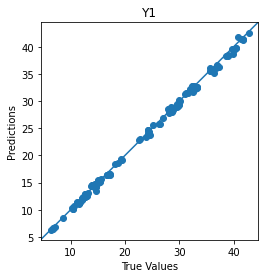

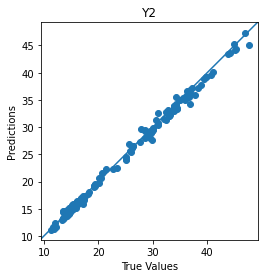

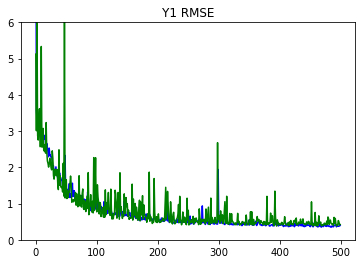

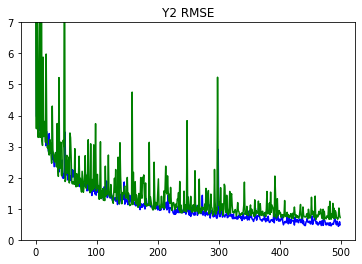

In [16]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)